In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

In [2]:
data_dir = "../data"
zscore_df_filename = f"{data_dir}/ukbb_zscore_df.pkl"
zscore_df = pd.read_pickle(zscore_df_filename)

phenotype_metafile = "/gpfs/commons/home/sbanerjee/work/npd/UKBB/npd_phenotypes_broad_categories.tsv"
phenotype_df = pd.read_csv(phenotype_metafile, sep="\t")

n_signif_metafile = "/gpfs/commons/home/sbanerjee/work/npd/UKBB/npd_n_signif.tsv"
n_signif_df = pd.read_csv(n_signif_metafile, sep="\t", header = None, names = ['phenotype', 'n_signif'])

In [3]:
zscore_df = zscore_df.loc[:, n_signif_df.loc[n_signif_df['n_signif'] >= 4, 'phenotype']]

In [4]:
phenotype_df

,Phenotype Code,Phenotype Name,Phenotype Class,Phenotype Description,variable_type,source,n_non_missing,n_missing,n_controls,n_cases
0,20488,Physically abused by family as a child,Abuse,Physically abused by family as a child,ordinal,phesant,117838,243356,NaN,NaN
1,20107_10,Father: Alzheimer's disease/dementia,Alzheimer,Illnesses of father: Alzheimer's disease/dementia,binary,phesant,312666,48528,297644.0,15022.0
2,20110_10,Mother: Alzheimer's disease/dementia,Alzheimer,Illnesses of mother: Alzheimer's disease/dementia,binary,phesant,331041,30153,302534.0,28507.0
3,20111_10,Siblings: Alzheimer's disease/dementia,Alzheimer,Illnesses of siblings: Alzheimer's disease/dem...,binary,phesant,279062,82132,277453.0,1609.0
4,20112_10,Adopted father: Alzheimer's disease/dementia,Alzheimer,Illnesses of adopted father: Alzheimer's disea...,binary,phesant,2562,358632,2416.0,146.0
...,...,...,...,...,...,...,...,...,...,...
312,20499,Ever sought or received professional help for ...,Stress,Ever sought or received professional help for ...,binary,phesant,117677,243517,71657.0,46020.0
313,20500,Ever suffered mental distress preventing usual...,Stress,Ever suffered mental distress preventing usual...,binary,phesant,116527,244667,77846.0,38681.0
314,F43,Diagnoses - main ICD10: F43 Reaction to severe...,Stress,Diagnoses - main ICD10: F43 Reaction to severe...,binary,icd10,361194,0,360967.0,227.0
315,O68,Diagnoses - main ICD10: O68 Labour and deliver...,Stress,Diagnoses - main ICD10: O68 Labour and deliver...,binary,icd10,361194,0,359312.0,1882.0


In [5]:
phenotype_ids = list(zscore_df.columns)
phenotype_names = [phenotype_df.loc[phenotype_df['Phenotype Code'] == x, 'Phenotype Name'].item() for x in phenotype_ids]
phenotype_categories = [phenotype_df.loc[phenotype_df['Phenotype Code'] == x, 'Phenotype Class'].item() for x in phenotype_ids]
unique_categories = list(set(phenotype_categories))

trait_indices = [np.array([i for i, x in enumerate(phenotype_categories) if x == catg]) for catg in unique_categories]
trait_colors  = {trait: color for trait, color in zip(unique_categories, (mpl_stylesheet.kelly_colors()))}

In [6]:
X_nan = np.array(zscore_df).T
X_nan_cent = X_nan - np.nanmean(X_nan, axis = 0, keepdims = True)
X_nan_mask = np.isnan(X_nan)
X_cent = np.nan_to_num(X_nan_cent, copy = True, nan = 0.0)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(X_nan_mask) / np.prod(X_cent.shape):.3f}")

We have 81 samples (phenotypes) and 37395 features (variants)
Fraction of Nan entries: 0.000


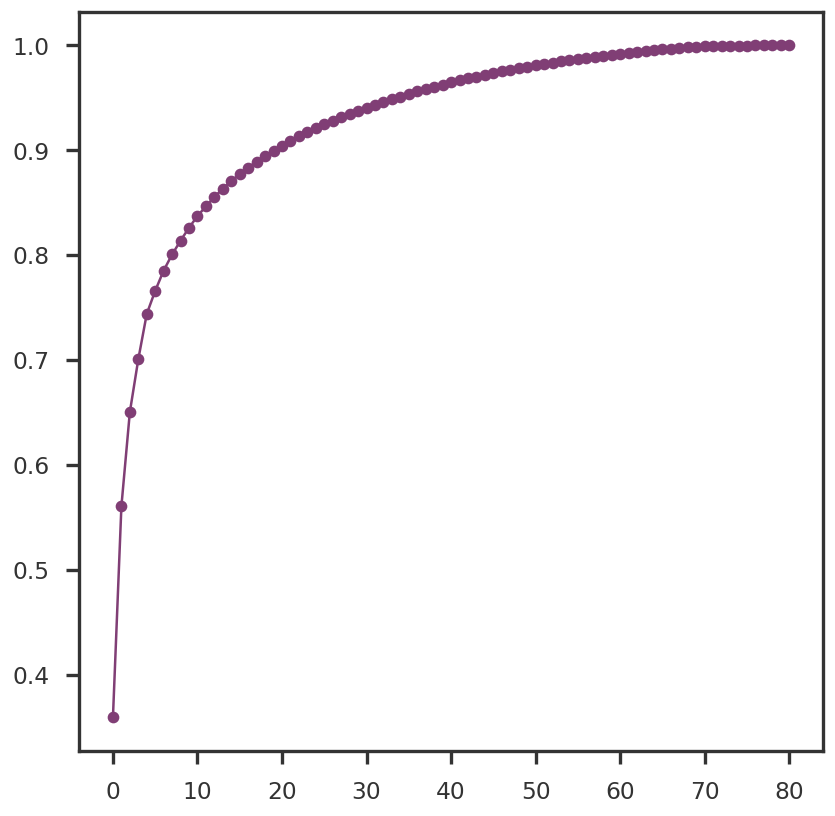

In [7]:
#| label: fig-input-pca-pve
#| fig-cap: "Proportion of variance explained by the principal components of the input matrix"

U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
S2 = np.square(S)
pcomp = U @ np.diag(S)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(S.shape[0]), np.cumsum(S2 / np.sum(S2)), 'o-')
plt.show()

# RPCA - IALM

In [8]:
1. / np.sqrt(10000)

0.01

In [9]:
rpca = IALM(max_iter = 10000, mu_update_method='admm', show_progress = True)
rpca.fit(X_cent, mask = X_nan_mask)

2023-10-31 16:02:57,084 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0052)
2023-10-31 16:02:57,954 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 0. Primal residual 0.852322. Dual residual 9.96361e-05
2023-10-31 16:09:55,518 | nnwmf.optimize.inexact_alm               | INFO    | Iteration 1000. Primal residual 1.01034e-07. Dual residual 2.19521e-08


In [10]:
with open (f"{data_dir}/ukbb_npd_lowrank_X_ialm.pkl", 'wb') as handle:
    pickle.dump(rpca.L_, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open (f"{data_dir}/ukbb_npd_lowrank_E_ialm.pkl", 'wb') as handle:
    pickle.dump(rpca.E_, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
mf_methods = ['ialm']

def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps, S


lowrank_X = dict()
loadings  = dict()
pcomps    = dict()
eigenvals = dict()

for method in mf_methods:
    with open (f"{data_dir}/ukbb_npd_lowrank_X_{method}.pkl", 'rb') as handle:
        lowrank_X[method] = pickle.load(handle)
        
loadings['tsvd'], pcomps['tsvd'], eigenvals['tsvd'] = get_principal_components(X_cent)
for m in mf_methods:
    loadings[m], pcomps[m], eigenvals[m] = get_principal_components(lowrank_X[m])

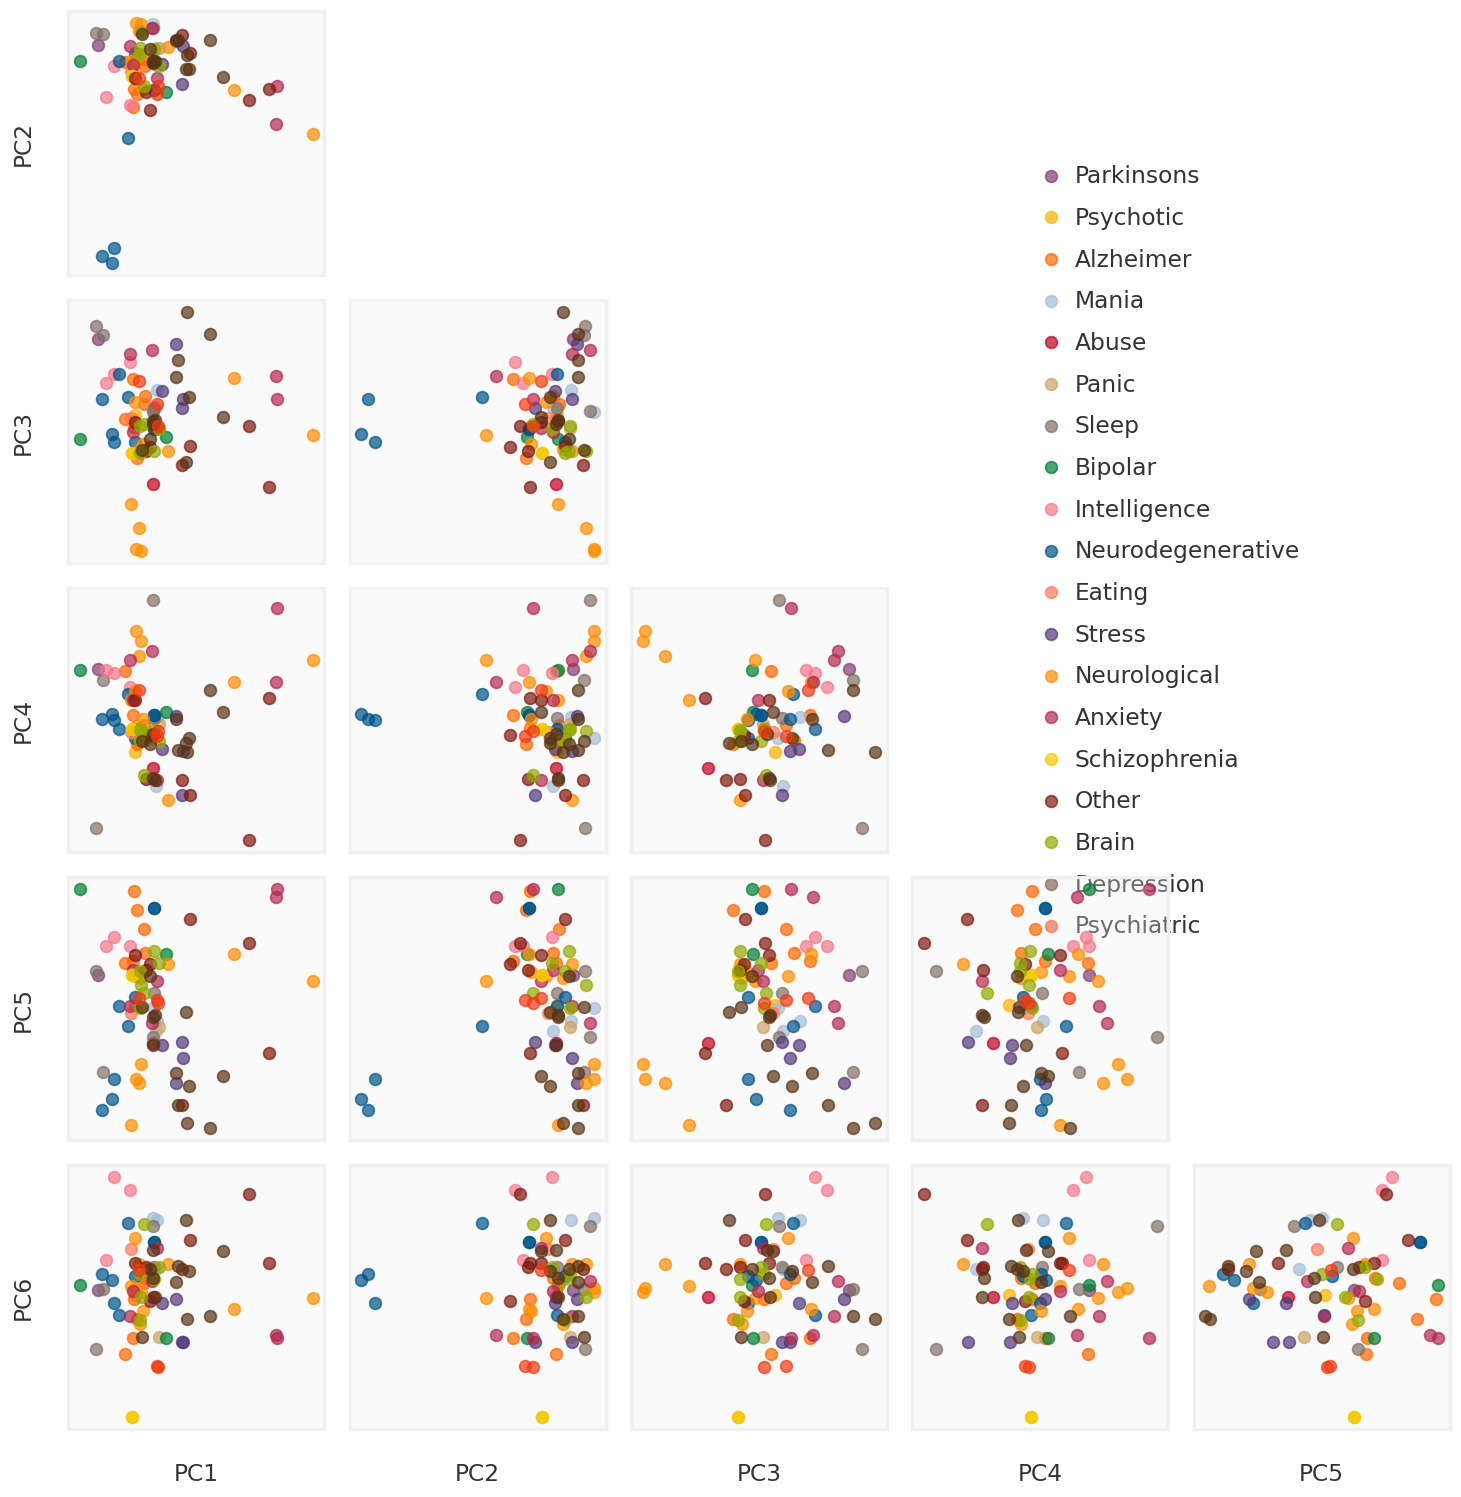

In [12]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps['ialm'], phenotype_categories, unique_categories)
plt.show()

In [13]:
def get_cos2_scores(pcomps):
    ntrait, npcomp = pcomps.shape
    x = np.zeros((ntrait, npcomp))
    for i in range(ntrait):
        cos2_trait = np.array([np.square(pcomps[i, pcidx]) for pcidx in range(npcomp)])
        x[i, :] = cos2_trait / np.sum(cos2_trait)
    return x

def stacked_barplot(ax, data, xlabels, colors, bar_width = 1.0, alpha = 1.0, showxlabels = False):
    '''
    Parameters
    ----------
        data: 
            dict() of scores. 
            - <key> : items for the stacked bars (e.g. traits or components)
            - <value> : list of scores for the items. All dict entries must have the same length of <value>
        xlabels: 
            label for each entry in the data <value> list. Must be of same length of data <value>
        colors: 
            dict(<key>, <color>) corresponding to each data <key>.
    '''
    indices = np.arange(len(xlabels))
    bottom = np.zeros(len(xlabels))

    for item, weights in data.items():
        ax.bar(indices, weights, bar_width, label = item, bottom = bottom, color = colors[item], alpha = alpha)
        bottom += weights

    if showxlabels:
        ax.set_xticks(indices)
        ax.set_xticklabels(xlabels, rotation=90, ha='center')
        ax.tick_params(bottom = True, top = False, left = False, right = False,
                   labelbottom = True, labeltop = False, labelleft = False, labelright = False)
    else:
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)

    for side, border in ax.spines.items():
        border.set_visible(False)

    return


def structure_plot(ax, pcomps, trait_labels, comp_colors, npcomp, showxlabels = False):
    cos2_scores = get_cos2_scores(pcomps)[:, :npcomp]
    cos2_plot_data = {
        f"{i+1}" : cos2_scores[:, i] for i in range(npcomp)
    }
    stacked_barplot(ax, cos2_plot_data, trait_labels, comp_colors, alpha = 0.8, showxlabels = showxlabels)
    return

In [14]:
plot_methods = ['tsvd'] + mf_methods
plot_methods_names = {
    'tsvd' : 'Raw Data',
    'ialm' : 'RPCA-IALM',
    'nnm'  : 'NNM-FW',
    'nnm_sparse' : 'NNM-Sparse-FW',
}

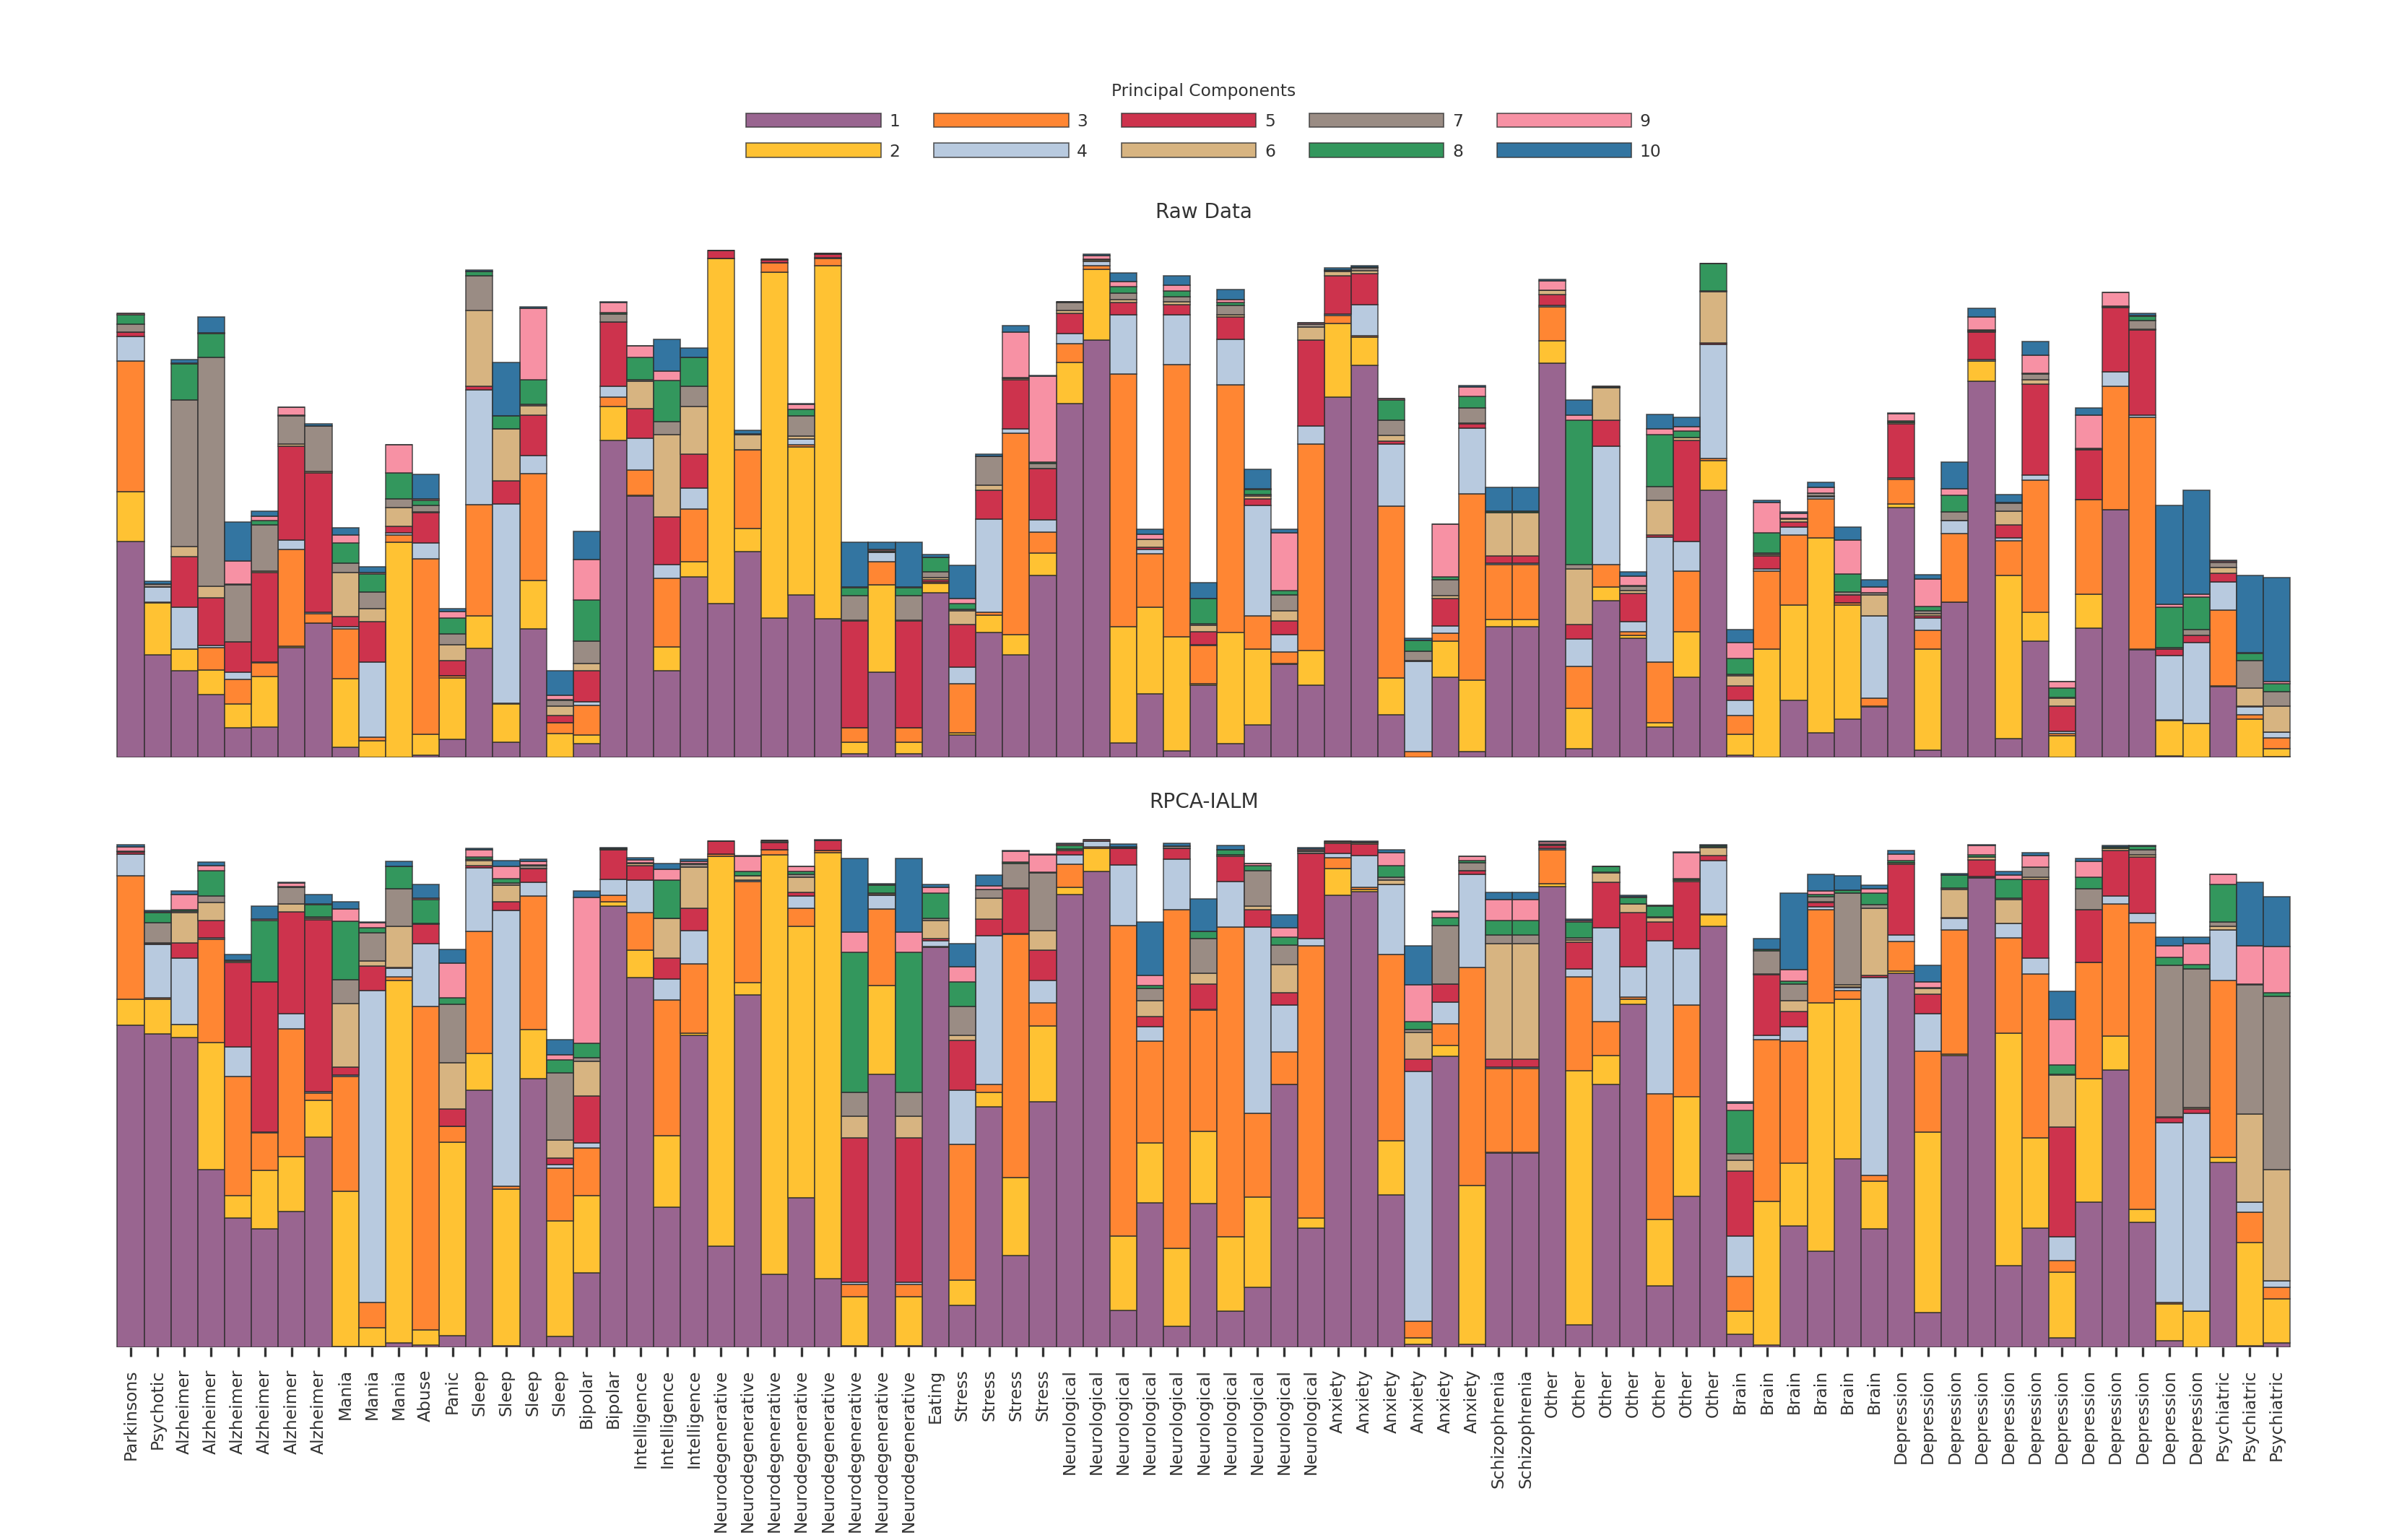

In [17]:
"""
Number of components to plot
"""
npcomp = 10
    
"""
Sort the traits / phenotypes
"""
trait_indices_sorted = list()
for idx in trait_indices:
    trait_indices_sorted += list(idx)

trait_labels_sorted = [phenotype_categories[i] for i in trait_indices_sorted]
pcomp_colors  = {f"{i+1}": color for i, color in enumerate(mpl_stylesheet.kelly_colors() + mpl_stylesheet.banskt_colors())}
    
fig = plt.figure(figsize = (28, 18))
gs = GridSpec(nrows = len(plot_methods) + 1, ncols=1, figure=fig, height_ratios=[0.3] + [1 for i in plot_methods])
ax = [None for i in range(len(plot_methods) + 1)]
ax[0] = fig.add_subplot(gs[0, 0])

for i, m in enumerate(plot_methods):
    iplot = i + 1
    showxlabels = True if iplot == len(plot_methods) else False
    #showxlabels = False
    ax[iplot] = fig.add_subplot(gs[iplot, 0])
    structure_plot(ax[iplot], pcomps[m][trait_indices_sorted,:], trait_labels_sorted, pcomp_colors, npcomp, showxlabels = showxlabels)
    ax[iplot].set_title(plot_methods_names[m])
    
plt_handles, plt_labels = ax[i].get_legend_handles_labels()
ax[0].legend(plt_handles, plt_labels, 
             loc = 'lower center', bbox_to_anchor=(0.5, 0), title = "Principal Components",
             frameon = False, handlelength = 8, ncol = 5)
for side, border in ax[0].spines.items():
    border.set_visible(False)
ax[0].tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)

#legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.tight_layout(h_pad = 2.0)
plt.show()